## Geodesic Exploration
In this notebook, I explore the creation, interpolation, and sampling of geodesics. Geodesics are the shortest path that form on a Riemannian manifold. 
For the VAE, this manifold arises from the image of the decoder from the latent space. Counterintuitively, the shortest path in the latent space (drawn as a Euclidean straight line) may not form the shortest path on the manifold and may even traverse off the data manifold. This property comes from the non-linearity of the decoder.

To find the geodesic, the Stochman library was used. Essentially, a Riemannian manifold operates in a Euclidean way when steps are infinitesimally small and in this way it can be walked.

In [1]:
import torch
from stochman.geodesic import geodesic_minimizing_energy
from stochman.curves import CubicSpline

from models.vae import VariationalAutoencoder

from utils.geodesic import find_geodesic
from utils.visualize import plot_overlapped

device = torch.device("cpu")

hidden_dim = 2
model = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load("./pretrained_models/vae.pth", map_location=device, weights_only=True))


<All keys matched successfully>

Using device: cpu


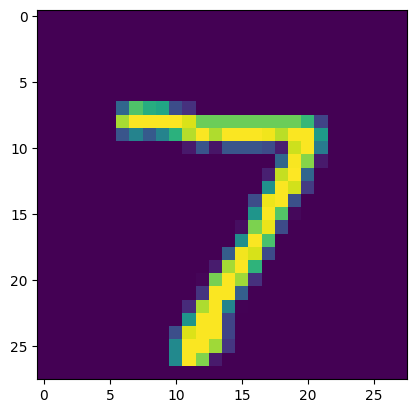

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ]
    )

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

print(f"Using device: {device}")


x_train, y_train = next(iter(train_loader))
x_train = x_train[:1]
y_train = y_train[:1]

x_test, y_test = next(iter(test_loader))

from collections import defaultdict

vals = defaultdict(list)

model.eval()
with torch.no_grad():
    for x, y in train_loader:
        _, z, _, _ = model(x)
        for i in range(len(y)):
            y_val = y[i].item()
            vals[y_val].append(z[i])

plt.imshow(x_train.reshape((28, 28, 1)))
plt.imshow(x_test.reshape((28, 28, 1)))


In [14]:
model.eval()
with torch.no_grad():
    _, z1, _, _ = model(x_train)
    _, z2, _, _ = model(x_test)
curve = find_geodesic(model, z1, z2)

tensor([6.7899], grad_fn=<SumBackward1>)

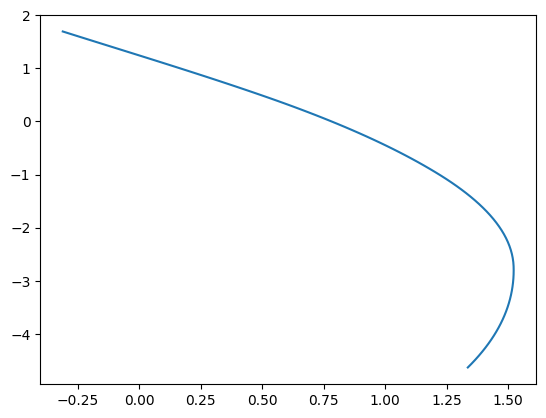

In [15]:
curve.plot()
curve.euclidean_length()

### Two points from the same class (number 5)

Geodesic length: 9.491792678833008
Euclidean length: 8.738334655761719


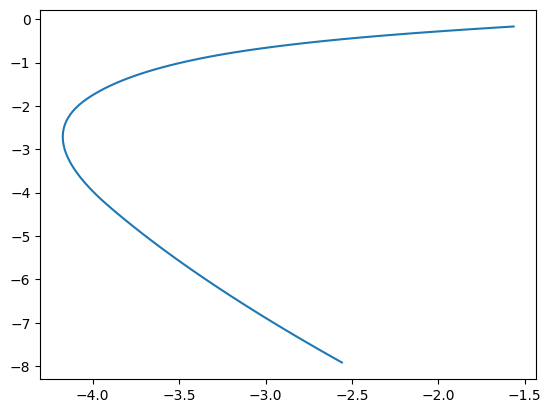

In [3]:
z1 = vals[5][0]
z2 = vals[5][1]
curve = find_geodesic(model, z1, z2)
curve.plot()
geodesic_distance = curve.euclidean_length().item()
euclidean_distance = torch.norm(z1 - z2, p=1)
print(f"Geodesic length: {geodesic_distance}")
print(f"Euclidean length: {euclidean_distance}")

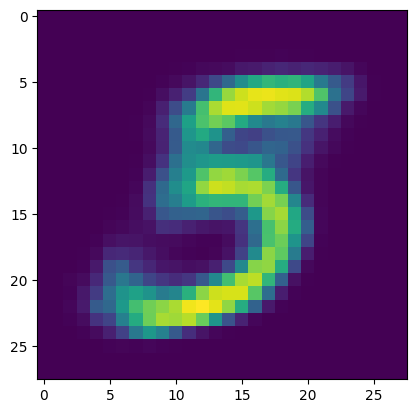

In [4]:
img = model.decoder(z1).reshape(torch.Size([1, 1, 28, 28])).squeeze().detach().cpu().numpy()
plt.imshow(img)

### Interpolation between the two latent points following the geodesic

Curve has geodesic length: 9.491792678833008


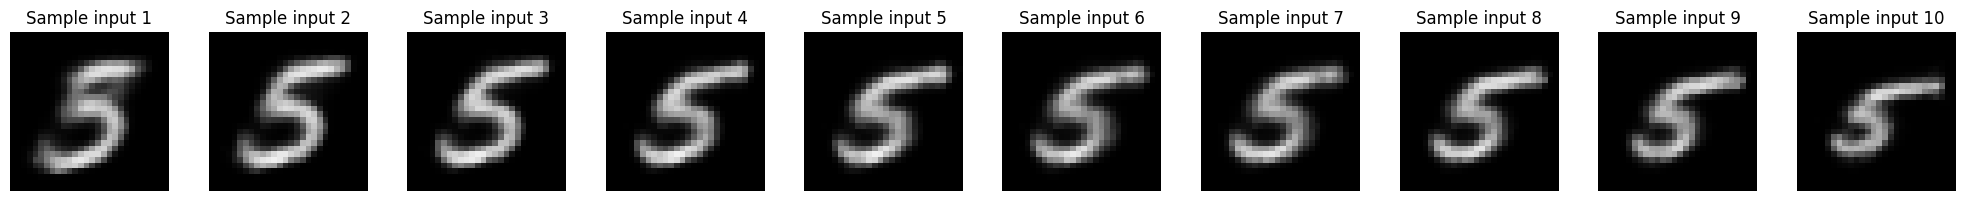

In [4]:
from utils.sampling import geodesic_interpolation_z
from utils.visualize import visualize_samples_only
samples = geodesic_interpolation_z(model, z1, z2, num_steps=10)
visualize_samples_only(samples)

### Euclidean Interpolation

Euclidean length: 7.807739734649658


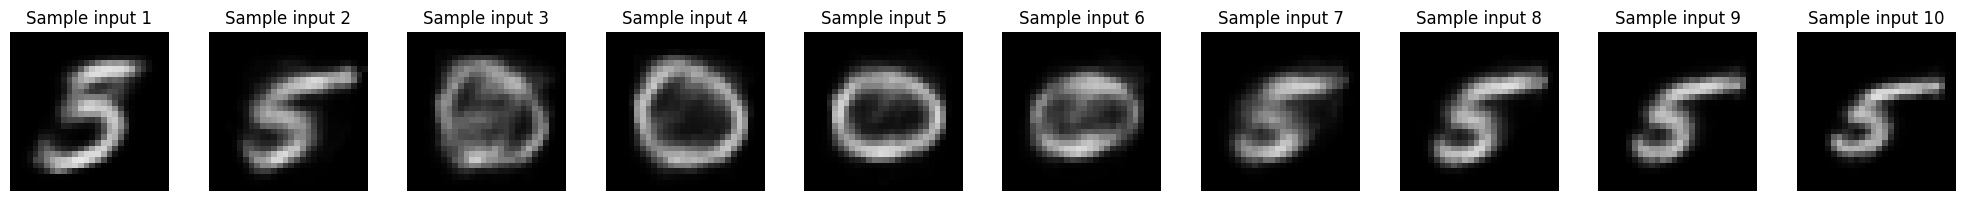

In [5]:
from utils.sampling import euclidean_interpolation_z
from utils.visualize import visualize_samples_only
samples = euclidean_interpolation_z(model, z1, z2, num_steps=10)
visualize_samples_only(samples)

### Two points from the different classes (number 0 and 1)
Here, we are expecting a farther distance than the previous one. This hypothesis stems from the intuition that the features of a zero and a 1 are quite different and therefore the two should find themselves farther apart on the data manifold.

Geodesic length: 7.760730743408203
Euclidean length: 8.962126731872559


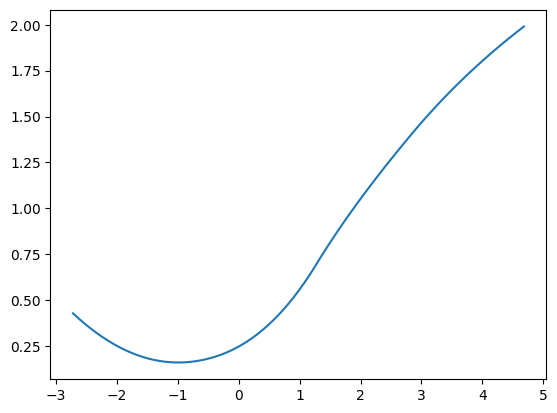

In [20]:
z1 = vals[0][0]
z2 = vals[1][0]
curve = find_geodesic(model, z1, z2)
curve.plot()
geodesic_distance = curve.euclidean_length().item()
euclidean_distance = torch.norm(z1 - z2, p=1)
print(f"Geodesic length: {geodesic_distance}")
print(f"Euclidean length: {euclidean_distance}")

### Interpolation between the two latent points following the geodesic

Curve has geodesic length: 9.33247184753418


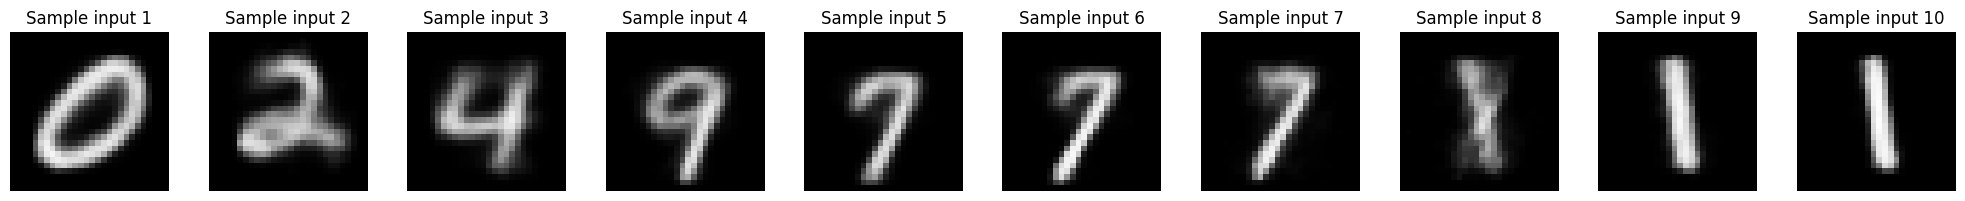

In [10]:
from utils.sampling import geodesic_interpolation_z
from utils.visualize import visualize_samples_only
samples = geodesic_interpolation_z(model, z1, z2, num_steps=10)
visualize_samples_only(samples)

### Euclidean Interpolation

Euclidean length: 8.847675323486328


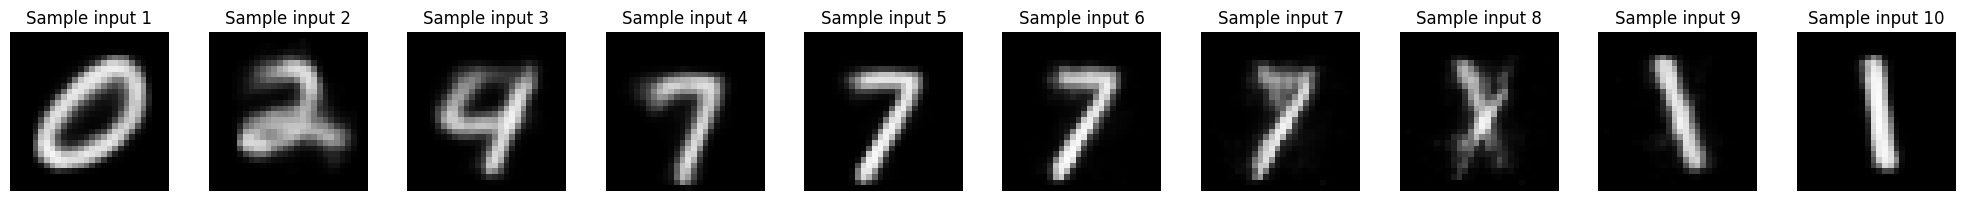

In [11]:
from utils.sampling import euclidean_interpolation_z
from utils.visualize import visualize_samples_only
samples = euclidean_interpolation_z(model, z1, z2, num_steps=10)
visualize_samples_only(samples)

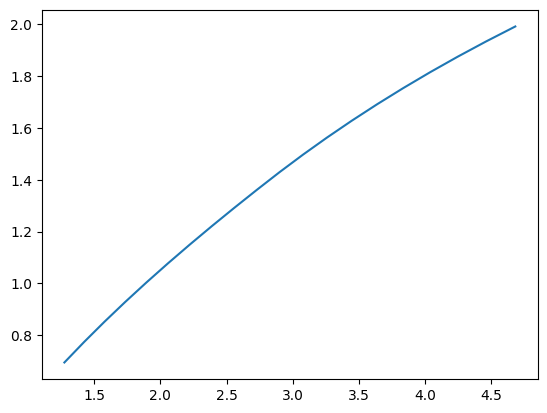

In [22]:
import matplotlib.pyplot as plt
from utils.geodesic import points_on_geodesic

points, t = points_on_geodesic(curve, 20, 0, 0.5)

ax= None
plot_in = ax or plt
if ax is not None:
    t = t.detach().numpy()
    points = points.detach().numpy()

figs = []
for b in range(points.shape[0]):
    fig = plot_in.plot(points[b, :, 0], points[b, :, 1])
    figs.append(fig)



[<Figure size 640x480 with 1 Axes>]

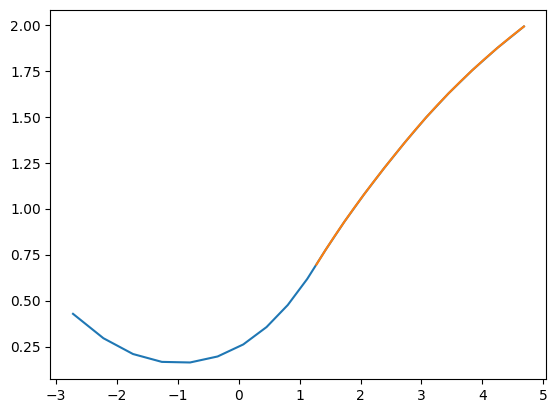

In [23]:
whole_curve, t= points_on_geodesic(curve, 20, 0, 1)
half_curve, t2 = points_on_geodesic(curve, 20, 0, 0.5)
plot_overlapped(whole_curve, half_curve, plot_in=plt, t=t)

In [24]:
points, t2 = points_on_geodesic(curve, 20, 0, 0.1)

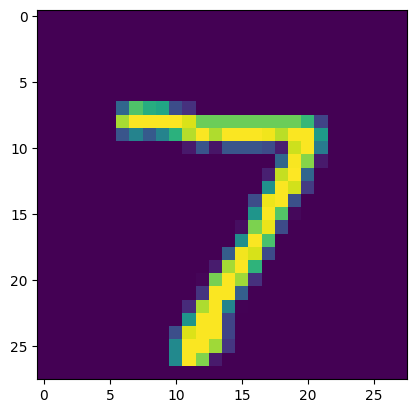

In [25]:
plt.imshow(x_test.reshape((28, 28, 1)))

Curve 0 has geodesic length: 2.0745911598205566
Curve 1 has geodesic length: 7.485837459564209
Curve 2 has geodesic length: 8.794539451599121
Curve 3 has geodesic length: 8.538740158081055
Curve 4 has geodesic length: 6.6154584884643555
Curve 5 has geodesic length: 4.787336349487305
Curve 6 has geodesic length: 8.050405502319336
Curve 7 has geodesic length: 6.423171520233154
Curve 8 has geodesic length: 7.030052185058594
Curve 9 has geodesic length: 5.938480377197266


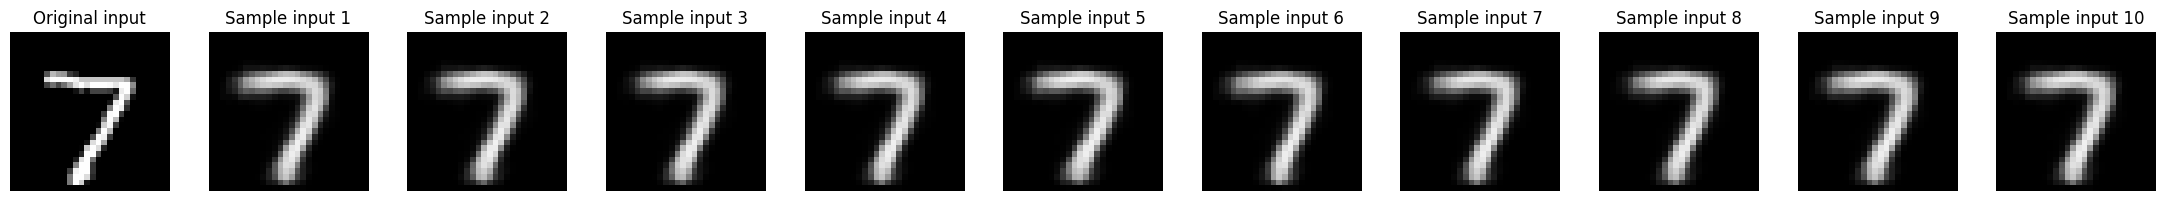

In [20]:
from utils.sampling import geodesic_sampling_close
from utils.visualize import visualize_samples

samples = geodesic_sampling_close(model, vals, x_test, 1, torch.device("cpu"), num_samples=10)
visualize_samples(x_test, samples)

In [21]:
import torch
from models.cnn import CustomCNN

# Retrieving pred model
cnn = CustomCNN(1, 10)
cnn.load_state_dict(torch.load("pretrained_models/CNN.pth"))

<All keys matched successfully>

In [22]:
from utils.visualize import visualize_img_pred
# Retrieving one correct prediction and one misprediction
correct = None
incorrect = None
for img, label in test_loader:
    pred = cnn.predict(img)
    if pred == label and correct is None:
        correct = (img, pred)
    elif pred != label and incorrect is None:
        incorrect = (img, pred)
    
    if correct is not None and incorrect is not None:
        break

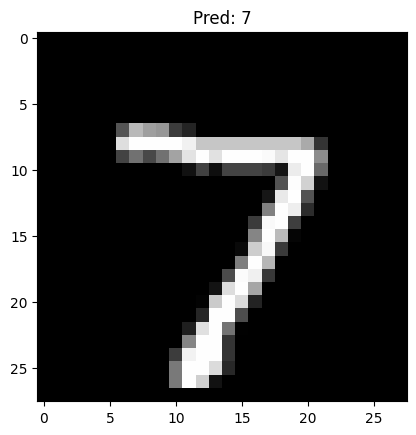

In [16]:
visualize_img_pred(correct[0], correct[1])

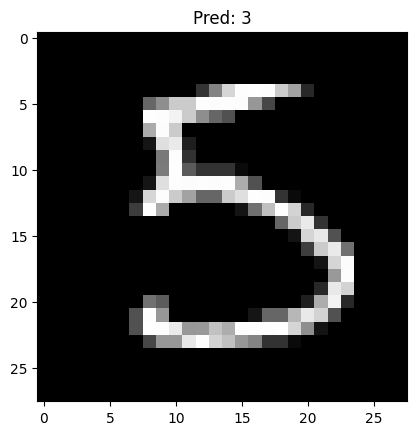

In [17]:
visualize_img_pred(incorrect[0], incorrect[1])

Curve 0 has geodesic length: 1.9284156560897827
Curve 1 has geodesic length: 0.7720723748207092
Curve 2 has geodesic length: 0.9669098258018494
Curve 3 has geodesic length: 0.9573140144348145
Curve 4 has geodesic length: 0.8353136777877808


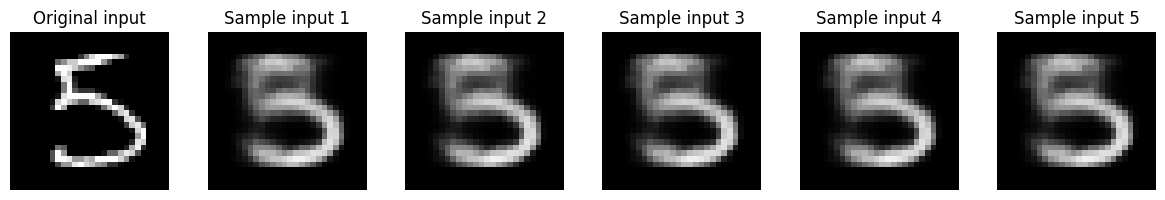

In [23]:
from utils.sampling import geodesic_sampling_close
from utils.visualize import visualize_samples

samples = geodesic_sampling_close(model, vals, incorrect[0], incorrect[1], torch.device("cpu"), num_samples=5)
visualize_samples(incorrect[0], samples)

Curve 0 has geodesic length: 1.9294041395187378
Curve 1 has geodesic length: 0.7724747061729431
Curve 2 has geodesic length: 0.9667968153953552
Curve 3 has geodesic length: 0.9572725296020508
Curve 4 has geodesic length: 0.8351554870605469


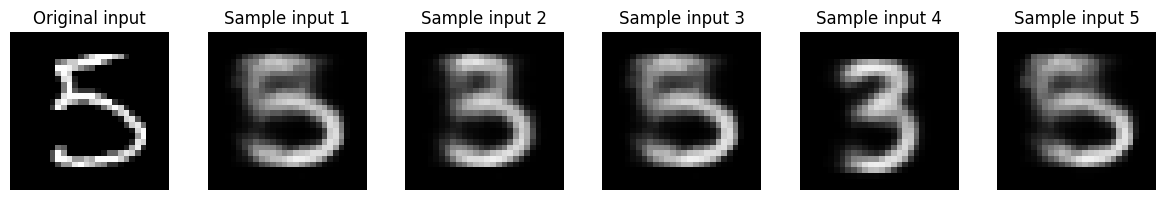

In [24]:
from utils.sampling import geodesic_sampling_whole
from utils.visualize import visualize_samples

samples = geodesic_sampling_whole(model, vals, incorrect[0], incorrect[1], torch.device("cpu"), num_samples=5)
visualize_samples(incorrect[0], samples)